In [4]:
import numpy as np
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    SceneGraph,
    Simulator,
    SnoptSolver,
    Solve,
    TrajectorySource,
)
from pydrake.examples import AcrobotGeometry, AcrobotPlant, PendulumPlant, PendulumState

# from underactuated import ConfigureParser, running_as_notebook
# from underactuated.jupyter import AdvanceToAndVisualize
# from underactuated.pendulum import PendulumVisualizer

<>:69: SyntaxWarning: invalid escape sequence '\d'
<>:69: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_107087/3693404703.py:69: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel("$\dot{q}$")


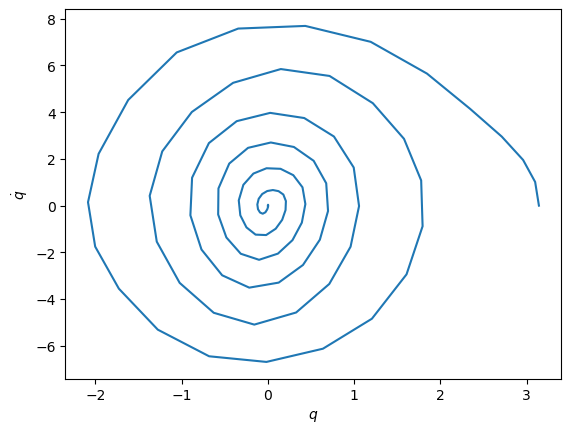

None

NameError: name 'PendulumVisualizer' is not defined

In [7]:
def pend_dircol():
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()

    N = 21
    max_dt = 0.5
    N * max_dt
    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=N,
        minimum_time_step=0.05,
        maximum_time_step=max_dt,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = 3.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = PendulumState()
    initial_state.set_theta(0.0)
    initial_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        initial_state.get_value(),
        initial_state.get_value(),
        dircol.initial_state(),
    )
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(
    #     dircol.initial_state() == initial_state.get_value())

    final_state = PendulumState()
    final_state.set_theta(np.pi)
    final_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        final_state.get_value(), final_state.get_value(), dircol.final_state()
    )
    # dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0] ** 2)

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], [initial_state.get_value(), final_state.get_value()]
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)

    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )

    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # Animate the result.
    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_trajectory)
    display(HTML(ani.to_jshtml()))


pend_dircol()

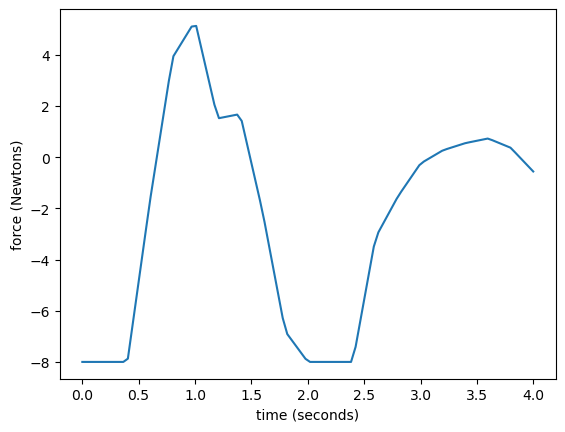

None

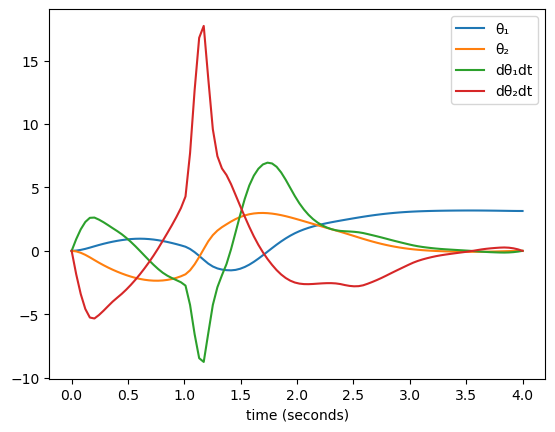

None

NameError: name 'AdvanceToAndVisualize' is not defined

In [8]:
def dircol_acrobot():
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()

    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=21,
        minimum_time_step=0.05,
        maximum_time_step=0.2,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    # Add input limits.
    torque_limit = 8.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = (0.0, 0.0, 0.0, 0.0)
    prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

    final_state = (np.pi, 0.0, 0.0, 0.0)
    prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
    # dircol.AddLinearConstraint(dircol.final_state() == final_state)

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0] ** 2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    # Give an initial guess from a solution I like.
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 0.2, 1.4, 2.0, 4.0],
        np.column_stack(
            (
                initial_state,
                [0.35, -0.71, 2.63, -5.34],
                [-1.19, 0.77, -6.87, 15.17],
                [1.12, 2.48, 5.99, -3.22],
                final_state,
            )
        ),
    )
    # This initial guess is enough on some platforms. (◡︵◡)
    # initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    #    [0.0, 4.0], np.column_stack((initial_state, final_state))
    # )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    solver = SnoptSolver()
    solver_id = solver.solver_id()
    major_tol = 1e-3
    minor_tol = 1e-3
    prog.SetSolverOption(solver_id, "Feasibility tolerance", major_tol)
    prog.SetSolverOption(solver_id, "Major feasibility tolerance", major_tol)
    prog.SetSolverOption(solver_id, "Major optimality tolerance", major_tol)
    prog.SetSolverOption(solver_id, "Minor feasibility tolerance", minor_tol)
    prog.SetSolverOption(solver_id, "Minor optimality tolerance", minor_tol)
    result = Solve(prog)
    assert result.is_success()

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_values = u_trajectory.vector_values(times)

    plt.figure()
    plt.plot(times, u_values.T)
    plt.xlabel("time (seconds)")
    plt.ylabel("force (Newtons)")
    display(plt.show())

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    x_values = x_trajectory.vector_values(times)

    plt.figure()
    plt.plot(times, x_values.T, label=["θ₁", "θ₂", "dθ₁dt", "dθ₂dt"])
    plt.xlabel("time (seconds)")
    plt.legend()
    display(plt.show())

    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, source.get_output_port(0), scene_graph)
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-4.0, 4.0], ylim=[-4.0, 4.0], show=False
        )
    )
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))
    simulator = Simulator(builder.Build())

    # Simulate and animate
    AdvanceToAndVisualize(
        simulator,
        visualizer,
        x_trajectory.end_time() if running_as_notebook else 0.1,
    )

    return x_trajectory, u_trajectory


x_trajectory, u_trajectory = dircol_acrobot()